In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 256) 
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [46]:
#torch.manual_seed(7)

In [47]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_66957/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_66957/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [48]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_66957/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_66957/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [49]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [50]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []
tacc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()

    tacc.append(tcorr/ttot)
    
    for i in range(len(lay)):
        if i > 0 and i <= len(lay)-1:
            di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:00<00:00, 239.77it/s]


Epoch 0/100, Loss: 0.006009039934724569, train dataset accuracy: 88.94833333333334
test dataset accuracy: 94.63%


100%|██████████| 235/235 [00:00<00:00, 266.58it/s]


Epoch 1/100, Loss: 0.006062398198992014, train dataset accuracy: 94.68166666666667
test dataset accuracy: 95.51%


100%|██████████| 235/235 [00:00<00:00, 297.43it/s]


Epoch 2/100, Loss: 0.009659824892878532, train dataset accuracy: 95.05333333333333
test dataset accuracy: 95.28%


100%|██████████| 235/235 [00:00<00:00, 299.40it/s]


Epoch 3/100, Loss: 0.004291075747460127, train dataset accuracy: 95.21666666666667
test dataset accuracy: 95.28%


100%|██████████| 235/235 [00:00<00:00, 293.31it/s]


Epoch 4/100, Loss: 0.006205153651535511, train dataset accuracy: 95.235
test dataset accuracy: 95.0%


100%|██████████| 235/235 [00:00<00:00, 278.96it/s]


Epoch 5/100, Loss: 0.00580282649025321, train dataset accuracy: 94.92166666666667
test dataset accuracy: 95.37%


100%|██████████| 235/235 [00:00<00:00, 299.26it/s]


Epoch 6/100, Loss: 0.008661812171339989, train dataset accuracy: 95.15166666666667
test dataset accuracy: 95.21%


100%|██████████| 235/235 [00:00<00:00, 279.36it/s]


Epoch 7/100, Loss: 0.010190614499151707, train dataset accuracy: 94.97166666666666
test dataset accuracy: 94.51%


100%|██████████| 235/235 [00:00<00:00, 290.09it/s]


Epoch 8/100, Loss: 0.010721180588006973, train dataset accuracy: 94.71666666666667
test dataset accuracy: 94.87%


100%|██████████| 235/235 [00:00<00:00, 275.81it/s]


Epoch 9/100, Loss: 0.011585288681089878, train dataset accuracy: 94.86666666666666
test dataset accuracy: 94.79%


100%|██████████| 235/235 [00:00<00:00, 291.65it/s]


Epoch 10/100, Loss: 0.005503735039383173, train dataset accuracy: 94.89833333333333
test dataset accuracy: 94.81%


100%|██████████| 235/235 [00:00<00:00, 300.29it/s]


Epoch 11/100, Loss: 0.007554414216428995, train dataset accuracy: 94.57666666666667
test dataset accuracy: 95.63%


100%|██████████| 235/235 [00:00<00:00, 280.46it/s]


Epoch 12/100, Loss: 0.01293940283358097, train dataset accuracy: 94.80333333333333
test dataset accuracy: 94.28%


100%|██████████| 235/235 [00:00<00:00, 283.68it/s]


Epoch 13/100, Loss: 0.010654688812792301, train dataset accuracy: 94.78833333333333
test dataset accuracy: 94.75%


100%|██████████| 235/235 [00:00<00:00, 298.05it/s]


Epoch 14/100, Loss: 0.009469050914049149, train dataset accuracy: 94.3
test dataset accuracy: 93.96%


100%|██████████| 235/235 [00:00<00:00, 301.22it/s]


Epoch 15/100, Loss: 0.012311032973229885, train dataset accuracy: 94.16833333333334
test dataset accuracy: 94.77%


100%|██████████| 235/235 [00:00<00:00, 295.88it/s]


Epoch 16/100, Loss: 0.008631810545921326, train dataset accuracy: 95.115
test dataset accuracy: 94.97%


100%|██████████| 235/235 [00:00<00:00, 280.17it/s]


Epoch 17/100, Loss: 0.005552801303565502, train dataset accuracy: 95.29
test dataset accuracy: 95.24%


100%|██████████| 235/235 [00:02<00:00, 116.73it/s]


Epoch 18/100, Loss: 0.00521584739908576, train dataset accuracy: 95.06666666666666
test dataset accuracy: 95.25%


100%|██████████| 235/235 [00:00<00:00, 283.79it/s]


Epoch 19/100, Loss: 0.004208622965961695, train dataset accuracy: 95.18
test dataset accuracy: 94.89%


100%|██████████| 235/235 [00:00<00:00, 297.75it/s]


Epoch 20/100, Loss: 0.007682236842811108, train dataset accuracy: 95.57833333333333
test dataset accuracy: 94.96%


100%|██████████| 235/235 [00:00<00:00, 258.98it/s]


Epoch 21/100, Loss: 0.007545111235231161, train dataset accuracy: 95.695
test dataset accuracy: 95.0%


100%|██████████| 235/235 [00:00<00:00, 300.54it/s]


Epoch 22/100, Loss: 0.002599555067718029, train dataset accuracy: 95.905
test dataset accuracy: 94.48%


100%|██████████| 235/235 [00:00<00:00, 297.56it/s]


Epoch 23/100, Loss: 0.010539425536990166, train dataset accuracy: 95.33666666666667
test dataset accuracy: 95.39%


100%|██████████| 235/235 [00:00<00:00, 299.48it/s]


Epoch 24/100, Loss: 0.002474127570167184, train dataset accuracy: 95.635
test dataset accuracy: 94.29%


100%|██████████| 235/235 [00:00<00:00, 278.59it/s]


Epoch 25/100, Loss: 0.008579575456678867, train dataset accuracy: 95.55666666666667
test dataset accuracy: 95.0%


100%|██████████| 235/235 [00:00<00:00, 297.95it/s]


Epoch 26/100, Loss: 0.00799868255853653, train dataset accuracy: 95.175
test dataset accuracy: 94.18%


100%|██████████| 235/235 [00:00<00:00, 297.07it/s]


Epoch 27/100, Loss: 0.012420952320098877, train dataset accuracy: 95.385
test dataset accuracy: 95.37%


100%|██████████| 235/235 [00:00<00:00, 297.32it/s]


Epoch 28/100, Loss: 0.006282879039645195, train dataset accuracy: 95.32
test dataset accuracy: 94.86%


100%|██████████| 235/235 [00:00<00:00, 259.02it/s]


Epoch 29/100, Loss: 0.004734954331070185, train dataset accuracy: 95.3
test dataset accuracy: 95.2%


100%|██████████| 235/235 [00:00<00:00, 296.26it/s]


Epoch 30/100, Loss: 0.0030534754041582346, train dataset accuracy: 95.59333333333333
test dataset accuracy: 95.33%


100%|██████████| 235/235 [00:00<00:00, 300.50it/s]


Epoch 31/100, Loss: 0.010750647634267807, train dataset accuracy: 95.77833333333334
test dataset accuracy: 95.21%


100%|██████████| 235/235 [00:00<00:00, 300.90it/s]


Epoch 32/100, Loss: 0.007909205742180347, train dataset accuracy: 95.655
test dataset accuracy: 94.89%


100%|██████████| 235/235 [00:00<00:00, 281.77it/s]


Epoch 33/100, Loss: 0.0066757844761013985, train dataset accuracy: 95.71166666666667
test dataset accuracy: 95.34%


100%|██████████| 235/235 [00:00<00:00, 298.45it/s]


Epoch 34/100, Loss: 0.00961057934910059, train dataset accuracy: 95.7
test dataset accuracy: 95.18%


100%|██████████| 235/235 [00:00<00:00, 243.54it/s]


Epoch 35/100, Loss: 0.009350819513201714, train dataset accuracy: 95.89166666666667
test dataset accuracy: 95.03%


100%|██████████| 235/235 [00:00<00:00, 257.59it/s]


Epoch 36/100, Loss: 0.007401673123240471, train dataset accuracy: 95.86166666666666
test dataset accuracy: 95.13%


100%|██████████| 235/235 [00:00<00:00, 260.79it/s]


Epoch 37/100, Loss: 0.007683526258915663, train dataset accuracy: 95.795
test dataset accuracy: 95.45%


100%|██████████| 235/235 [00:00<00:00, 301.44it/s]


Epoch 38/100, Loss: 0.008405331522226334, train dataset accuracy: 96.015
test dataset accuracy: 94.78%


100%|██████████| 235/235 [00:00<00:00, 303.79it/s]


Epoch 39/100, Loss: 0.008992316201329231, train dataset accuracy: 96.02333333333333
test dataset accuracy: 95.38%


100%|██████████| 235/235 [00:00<00:00, 294.83it/s]


Epoch 40/100, Loss: 0.005262343678623438, train dataset accuracy: 95.92166666666667
test dataset accuracy: 95.57%


100%|██████████| 235/235 [00:00<00:00, 276.94it/s]


Epoch 41/100, Loss: 0.004002113826572895, train dataset accuracy: 96.19166666666666
test dataset accuracy: 95.13%


100%|██████████| 235/235 [00:00<00:00, 292.35it/s]


Epoch 42/100, Loss: 0.003809700021520257, train dataset accuracy: 96.38666666666667
test dataset accuracy: 95.83%


100%|██████████| 235/235 [00:00<00:00, 297.38it/s]


Epoch 43/100, Loss: 0.007355872076004744, train dataset accuracy: 96.43166666666667
test dataset accuracy: 95.21%


100%|██████████| 235/235 [00:00<00:00, 288.24it/s]


Epoch 44/100, Loss: 0.008916488848626614, train dataset accuracy: 95.95
test dataset accuracy: 95.12%


100%|██████████| 235/235 [00:00<00:00, 290.09it/s]


Epoch 45/100, Loss: 0.003539984580129385, train dataset accuracy: 96.12333333333333
test dataset accuracy: 95.31%


100%|██████████| 235/235 [00:00<00:00, 296.15it/s]


Epoch 46/100, Loss: 0.005598710849881172, train dataset accuracy: 96.48833333333333
test dataset accuracy: 95.58%


100%|██████████| 235/235 [00:00<00:00, 300.97it/s]


Epoch 47/100, Loss: 0.007867914624512196, train dataset accuracy: 96.42
test dataset accuracy: 95.06%


100%|██████████| 235/235 [00:00<00:00, 302.47it/s]


Epoch 48/100, Loss: 0.003466868307441473, train dataset accuracy: 95.64333333333333
test dataset accuracy: 95.11%


100%|██████████| 235/235 [00:00<00:00, 295.33it/s]


Epoch 49/100, Loss: 0.0034018014557659626, train dataset accuracy: 96.395
test dataset accuracy: 95.7%


100%|██████████| 235/235 [00:00<00:00, 295.09it/s]


Epoch 50/100, Loss: 0.012938265688717365, train dataset accuracy: 96.34833333333333
test dataset accuracy: 94.3%


100%|██████████| 235/235 [00:00<00:00, 295.18it/s]


Epoch 51/100, Loss: 0.005413509439677, train dataset accuracy: 96.665
test dataset accuracy: 94.62%


100%|██████████| 235/235 [00:00<00:00, 283.31it/s]


Epoch 52/100, Loss: 0.006368937902152538, train dataset accuracy: 96.53666666666666
test dataset accuracy: 95.37%


100%|██████████| 235/235 [00:00<00:00, 298.72it/s]


Epoch 53/100, Loss: 0.010968332178890705, train dataset accuracy: 96.48
test dataset accuracy: 95.34%


100%|██████████| 235/235 [00:00<00:00, 295.79it/s]


Epoch 54/100, Loss: 0.004069950897246599, train dataset accuracy: 96.77833333333334
test dataset accuracy: 95.63%


100%|██████████| 235/235 [00:00<00:00, 296.75it/s]


Epoch 55/100, Loss: 0.004525778349488974, train dataset accuracy: 96.73166666666667
test dataset accuracy: 95.26%


100%|██████████| 235/235 [00:00<00:00, 278.24it/s]


Epoch 56/100, Loss: 0.004770821426063776, train dataset accuracy: 96.71666666666667
test dataset accuracy: 95.34%


100%|██████████| 235/235 [00:00<00:00, 299.33it/s]


Epoch 57/100, Loss: 0.004119666758924723, train dataset accuracy: 96.56833333333333
test dataset accuracy: 95.38%


100%|██████████| 235/235 [00:00<00:00, 301.97it/s]


Epoch 58/100, Loss: 0.0019502134528011084, train dataset accuracy: 96.63833333333334
test dataset accuracy: 95.59%


100%|██████████| 235/235 [00:00<00:00, 302.00it/s]


Epoch 59/100, Loss: 0.006545864976942539, train dataset accuracy: 96.65833333333333
test dataset accuracy: 95.57%


100%|██████████| 235/235 [00:00<00:00, 280.69it/s]


Epoch 60/100, Loss: 0.005775251425802708, train dataset accuracy: 96.89666666666666
test dataset accuracy: 95.53%


100%|██████████| 235/235 [00:00<00:00, 285.35it/s]


Epoch 61/100, Loss: 0.008480142802000046, train dataset accuracy: 96.90166666666667
test dataset accuracy: 95.36%


100%|██████████| 235/235 [00:00<00:00, 302.08it/s]


Epoch 62/100, Loss: 0.007277803495526314, train dataset accuracy: 96.725
test dataset accuracy: 95.46%


100%|██████████| 235/235 [00:00<00:00, 302.71it/s]


Epoch 63/100, Loss: 0.005512130446732044, train dataset accuracy: 96.86166666666666
test dataset accuracy: 95.68%


100%|██████████| 235/235 [00:00<00:00, 279.34it/s]


Epoch 64/100, Loss: 0.007938774302601814, train dataset accuracy: 96.94666666666667
test dataset accuracy: 95.21%


100%|██████████| 235/235 [00:00<00:00, 304.87it/s]


Epoch 65/100, Loss: 0.0033900036942213774, train dataset accuracy: 96.71333333333334
test dataset accuracy: 94.92%


100%|██████████| 235/235 [00:00<00:00, 292.42it/s]


Epoch 66/100, Loss: 0.006658676080405712, train dataset accuracy: 96.76333333333334
test dataset accuracy: 94.39%


100%|██████████| 235/235 [00:00<00:00, 296.29it/s]


Epoch 67/100, Loss: 0.01296176202595234, train dataset accuracy: 96.39166666666667
test dataset accuracy: 94.57%


100%|██████████| 235/235 [00:00<00:00, 276.84it/s]


Epoch 68/100, Loss: 0.00821780040860176, train dataset accuracy: 95.15166666666667
test dataset accuracy: 94.9%


100%|██████████| 235/235 [00:00<00:00, 306.63it/s]


Epoch 69/100, Loss: 0.0029316230211406946, train dataset accuracy: 96.09
test dataset accuracy: 94.76%


100%|██████████| 235/235 [00:00<00:00, 294.16it/s]


Epoch 70/100, Loss: 0.01211302075535059, train dataset accuracy: 95.965
test dataset accuracy: 94.84%


100%|██████████| 235/235 [00:00<00:00, 300.83it/s]


Epoch 71/100, Loss: 0.008347702212631702, train dataset accuracy: 96.41333333333333
test dataset accuracy: 95.4%


100%|██████████| 235/235 [00:00<00:00, 276.66it/s]


Epoch 72/100, Loss: 0.005845396313816309, train dataset accuracy: 96.91166666666666
test dataset accuracy: 95.78%


100%|██████████| 235/235 [00:00<00:00, 301.09it/s]


Epoch 73/100, Loss: 0.010111208073794842, train dataset accuracy: 97.0
test dataset accuracy: 95.76%


100%|██████████| 235/235 [00:00<00:00, 303.55it/s]


Epoch 74/100, Loss: 0.0020108032040297985, train dataset accuracy: 96.61666666666666
test dataset accuracy: 95.4%


100%|██████████| 235/235 [00:00<00:00, 294.17it/s]


Epoch 75/100, Loss: 0.008741329424083233, train dataset accuracy: 96.35666666666667
test dataset accuracy: 95.23%


100%|██████████| 235/235 [00:00<00:00, 283.17it/s]


Epoch 76/100, Loss: 0.002420020755380392, train dataset accuracy: 96.86833333333334
test dataset accuracy: 94.9%


100%|██████████| 235/235 [00:00<00:00, 293.71it/s]


Epoch 77/100, Loss: 0.002573608187958598, train dataset accuracy: 96.7
test dataset accuracy: 95.04%


100%|██████████| 235/235 [00:00<00:00, 288.49it/s]


Epoch 78/100, Loss: 0.0039159925654530525, train dataset accuracy: 97.11833333333334
test dataset accuracy: 96.01%


100%|██████████| 235/235 [00:00<00:00, 295.91it/s]


Epoch 79/100, Loss: 0.010085081681609154, train dataset accuracy: 97.20666666666666
test dataset accuracy: 94.03%


100%|██████████| 235/235 [00:00<00:00, 272.59it/s]


Epoch 80/100, Loss: 0.006346846465021372, train dataset accuracy: 96.71833333333333
test dataset accuracy: 95.74%


100%|██████████| 235/235 [00:00<00:00, 291.90it/s]


Epoch 81/100, Loss: 0.011498221196234226, train dataset accuracy: 96.97
test dataset accuracy: 95.71%


100%|██████████| 235/235 [00:00<00:00, 297.82it/s]


Epoch 82/100, Loss: 0.00755332363769412, train dataset accuracy: 97.07166666666667
test dataset accuracy: 95.71%


100%|██████████| 235/235 [00:00<00:00, 303.23it/s]


Epoch 83/100, Loss: 0.0009032035013660789, train dataset accuracy: 97.27
test dataset accuracy: 95.82%


100%|██████████| 235/235 [00:00<00:00, 272.52it/s]


Epoch 84/100, Loss: 0.00310761877335608, train dataset accuracy: 96.96333333333334
test dataset accuracy: 95.63%


100%|██████████| 235/235 [00:00<00:00, 287.66it/s]


Epoch 85/100, Loss: 0.0022928593680262566, train dataset accuracy: 96.52666666666667
test dataset accuracy: 95.54%


100%|██████████| 235/235 [00:00<00:00, 291.15it/s]


Epoch 86/100, Loss: 0.010004136711359024, train dataset accuracy: 96.99833333333333
test dataset accuracy: 95.25%


100%|██████████| 235/235 [00:00<00:00, 299.66it/s]


Epoch 87/100, Loss: 0.0008722673519514501, train dataset accuracy: 97.38666666666667
test dataset accuracy: 96.18%


100%|██████████| 235/235 [00:00<00:00, 278.17it/s]


Epoch 88/100, Loss: 0.004827843047678471, train dataset accuracy: 97.255
test dataset accuracy: 95.27%


100%|██████████| 235/235 [00:00<00:00, 292.19it/s]


Epoch 89/100, Loss: 0.0013807681389153004, train dataset accuracy: 97.39166666666667
test dataset accuracy: 95.99%


100%|██████████| 235/235 [00:00<00:00, 296.19it/s]


Epoch 90/100, Loss: 0.01093490980565548, train dataset accuracy: 96.26166666666667
test dataset accuracy: 91.63%


100%|██████████| 235/235 [00:00<00:00, 297.15it/s]


Epoch 91/100, Loss: 0.007763908710330725, train dataset accuracy: 95.79666666666667
test dataset accuracy: 95.33%


100%|██████████| 235/235 [00:00<00:00, 281.98it/s]


Epoch 92/100, Loss: 0.009446058422327042, train dataset accuracy: 95.45333333333333
test dataset accuracy: 95.15%


100%|██████████| 235/235 [00:00<00:00, 298.96it/s]


Epoch 93/100, Loss: 0.0012225412065163255, train dataset accuracy: 96.61666666666666
test dataset accuracy: 95.5%


100%|██████████| 235/235 [00:00<00:00, 296.36it/s]


Epoch 94/100, Loss: 0.006394974887371063, train dataset accuracy: 96.72833333333334
test dataset accuracy: 95.81%


100%|██████████| 235/235 [00:00<00:00, 281.60it/s]


Epoch 95/100, Loss: 0.003122663591057062, train dataset accuracy: 97.0
test dataset accuracy: 95.16%


100%|██████████| 235/235 [00:00<00:00, 283.06it/s]


Epoch 96/100, Loss: 0.00892945658415556, train dataset accuracy: 97.16666666666667
test dataset accuracy: 95.97%


100%|██████████| 235/235 [00:00<00:00, 304.88it/s]


Epoch 97/100, Loss: 0.00041652334039099514, train dataset accuracy: 97.41166666666666
test dataset accuracy: 95.89%


100%|██████████| 235/235 [00:00<00:00, 293.91it/s]


Epoch 98/100, Loss: 0.002657139440998435, train dataset accuracy: 97.54833333333333
test dataset accuracy: 96.01%


100%|██████████| 235/235 [00:00<00:00, 291.46it/s]


Epoch 99/100, Loss: 0.002911684103310108, train dataset accuracy: 97.11666666666666
test dataset accuracy: 95.12%


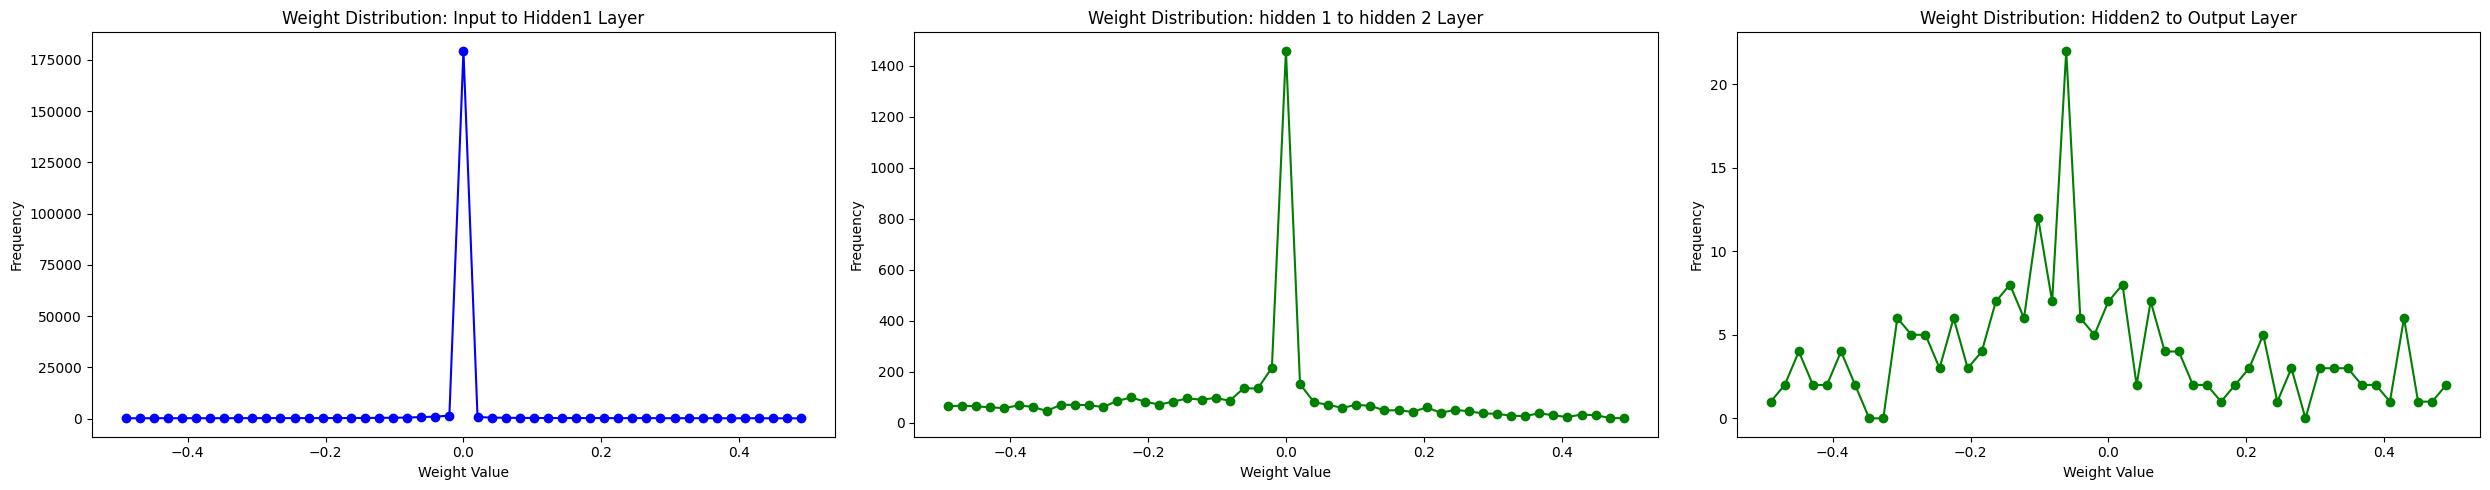

In [51]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [52]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 21261
Number of non-zero weights greater than 0.01 in layer 1: 6743
Number of non-zero weights greater than 0.01 in layer 3: 633


In [53]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.9860525510752185, 0.9877708594803731, 0.9902838654449118, 0.9858418717262095, 0.9861901841071142, 0.9867698276490662, 0.9901145902359896, 0.9867348847802315, 0.986317181104411, 0.9877729278925348, 0.9893711883779972, 0.9859114545970642, 0.9863754937110223, 0.9868352039911755, 0.9862698439499084, 0.9878587050279523, 0.987497126081275, 0.9864157763014727, 0.9881176225606288, 0.9854312274379919, 0.9863073444966604, 0.9876068562643239, 0.9868549676234606, 0.9896744168006468, 0.9860628337626807, 0.9885726259275861, 0.9855911424186319, 0.9858838991647728, 0.986266035537883, 0.9891128869858926, 0.9887896400585858, 0.9870285225047967, 0.9859545071047306, 0.987355842648558, 0.988035653666702, 0.987001347543545, 0.9905132816353233, 0.9874540730467306, 0.9877576022097709, 0.9875180647245521, 0.9875660742398462, 0.9857943117551535, 0.9860892860674584, 0.9860188591808167, 0.9884401368388991, 0.98605096795799, 0.9874378539229302, 0.9895037094883804, 0.9881521550053255, 0.9867403711078993, 0.98623

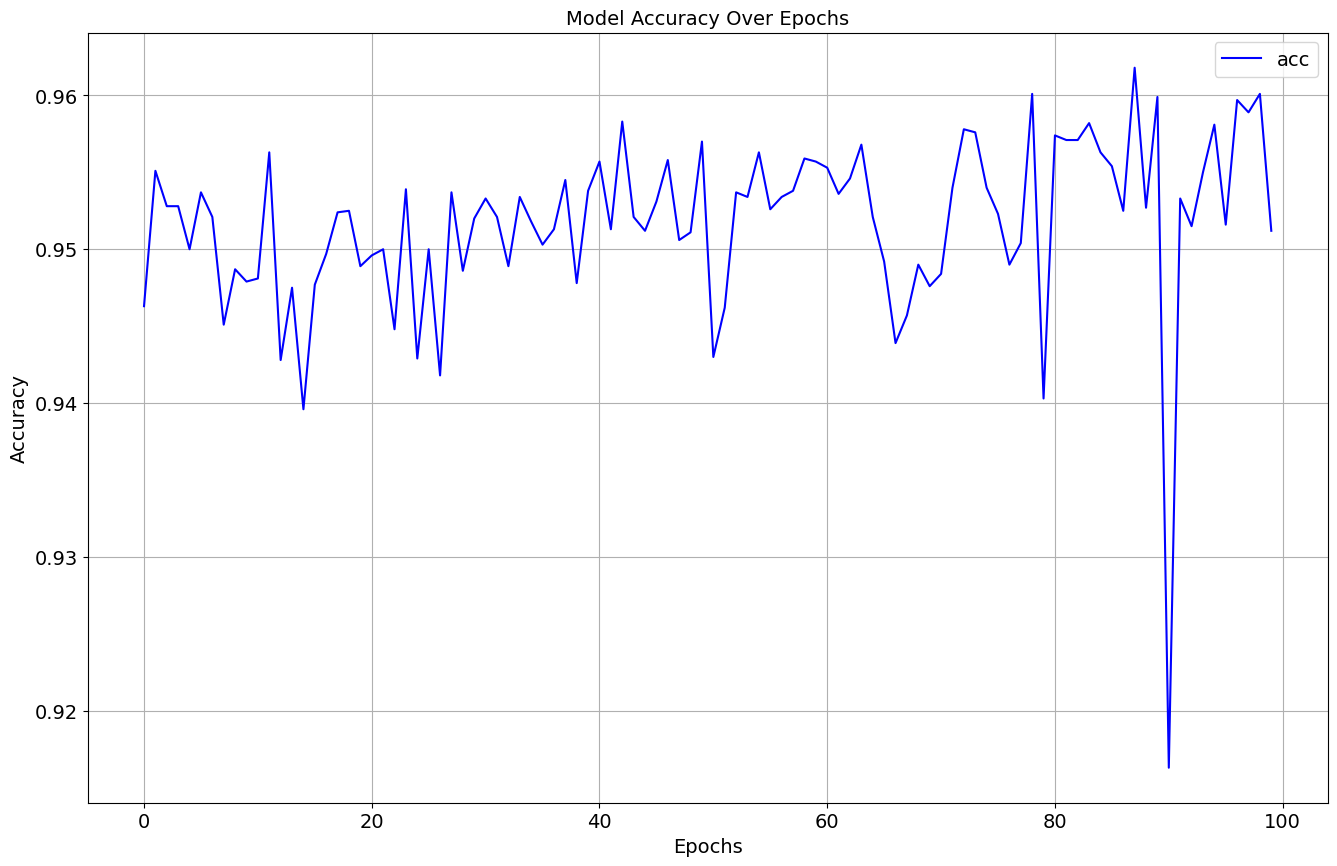

In [54]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [55]:
import pickle
with open('nbOnlineEveryEpochAcc0.pkl', 'wb') as f:
    pickle.dump(acc, f)

with open('nbOnlineEveryEpochTrainAcc0.pkl', 'wb') as f:
    pickle.dump(tacc, f)

torch.save(model.state_dict(), 'neuralBalanceModel0.pt')